In [82]:
### importing libraries
%matplotlib inline
from keras.layers.convolutional import Convolution2D, MaxPooling2D, Convolution1D
from keras.layers.core import Dense, Activation, Dropout, Flatten
from keras.models import Sequential
from keras.optimizers import SGD,RMSprop
from keras.datasets import mnist
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping

import numpy as np
import pandas as pd
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline


import matplotlib as mpl

#mpl.use('Agg')
import matplotlib.pyplot as plt
import time
timestr = time.strftime("%Y%m%d-%H%M%S")
print(timestr)

20170430-083511


In [5]:
df_train = pd.read_csv("../input/train.csv", parse_dates=['timestamp'])
df_test = pd.read_csv("../input/test.csv", parse_dates=['timestamp'])
df_macro = pd.read_csv("../input/macro.csv", parse_dates=['timestamp'])

df_train.head()

id  timestamp  full_sq  life_sq  floor  max_floor  material  build_year  \
0   1 2011-08-20       43     27.0    4.0        NaN       NaN         NaN   
1   2 2011-08-23       34     19.0    3.0        NaN       NaN         NaN   
2   3 2011-08-27       43     29.0    2.0        NaN       NaN         NaN   
3   4 2011-09-01       89     50.0    9.0        NaN       NaN         NaN   
4   5 2011-09-05       77     77.0    4.0        NaN       NaN         NaN   

   num_room  kitch_sq    ...      cafe_count_5000_price_2500  \
0       NaN       NaN    ...                               9   
1       NaN       NaN    ...                              15   
2       NaN       NaN    ...                              10   
3       NaN       NaN    ...                              11   
4       NaN       NaN    ...                             319   

  cafe_count_5000_price_4000 cafe_count_5000_price_high  \
0                          4                          0   
1                          3                          0   
2                          3                          0   
3                          2                          1   
4                        108                         17   

   big_church_count_5000  church_count_5000  mosque_count_5000  \
0                     13                 22                  1   
1                     15                 29                  1   
2                     11                 27                  0   
3                      4                  4                  0   
4                    135                236                  2   

   leisure_count_5000  sport_count_5000  market_count_5000  price_doc  
0                   0                52                  4    5850000  
1                  10                66                 14    6000000  
2                   4                67                 10    5700000  
3                   0                26                  3   13100000  
4                  91               195                 14   16331452  

[5 rows x 292 columns]

In [6]:
# This section added:  drop crazy data point
print( df_train.life_sq.max() )
df_train.drop(df_train[df_train["life_sq"] > 7000].index, inplace=True)
print( df_train.life_sq.max() )

7478.0
802.0


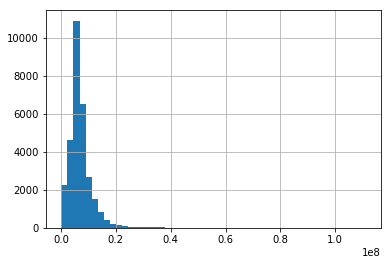

In [7]:
df_train['price_doc'].hist(bins=50)

In [8]:
y_train = df_train['price_doc'].values
id_test = df_test['id']

df_train.drop(['id', 'price_doc'], axis=1, inplace=True)
df_test.drop(['id'], axis=1, inplace=True)

# Build df_all = (df_train+df_test).join(df_macro)
num_train = len(df_train)
df_all = pd.concat([df_train, df_test])
df_all = df_all.join(df_macro, on='timestamp', rsuffix='_macro')
print(df_all.shape)

# Add month-year
month_year = (df_all.timestamp.dt.month + df_all.timestamp.dt.year * 100)
month_year_cnt_map = month_year.value_counts().to_dict()
df_all['month_year_cnt'] = month_year.map(month_year_cnt_map)

# Add week-year count
week_year = (df_all.timestamp.dt.weekofyear + df_all.timestamp.dt.year * 100)
week_year_cnt_map = week_year.value_counts().to_dict()
df_all['week_year_cnt'] = week_year.map(week_year_cnt_map)

# Add month and day-of-week
df_all['month'] = df_all.timestamp.dt.month
df_all['dow'] = df_all.timestamp.dt.dayofweek

# Other feature engineering
df_all['rel_floor'] = df_all['floor'] / df_all['max_floor'].astype(float)
df_all['rel_kitch_sq'] = df_all['kitch_sq'] / df_all['full_sq'].astype(float)

# Remove timestamp column (may overfit the model in train)
df_all.drop(['timestamp', 'timestamp_macro'], axis=1, inplace=True)

(38132, 390)


In [9]:
factorize = lambda t: pd.factorize(t[1])[0]

df_obj = df_all.select_dtypes(include=['object'])

X_all = np.c_[
    df_all.select_dtypes(exclude=['object']).values,
    np.array(list(map(factorize, df_obj.iteritems()))).T
]
print(X_all.shape)

X_train = X_all[:num_train]
X_test = X_all[num_train:]

(38132, 394)


In [10]:
# Deal with categorical values
df_numeric = df_all.select_dtypes(exclude=['object'])
df_obj = df_all.select_dtypes(include=['object']).copy()

for c in df_obj:
    df_obj[c] = pd.factorize(df_obj[c])[0]

df_values = pd.concat([df_numeric, df_obj], axis=1)

df_values=df_values.dropna(axis="columns", how='any')
df_values.shape

(38132, 244)

In [29]:
# Convert to numpy values
X_all = df_values.values
print(X_all.shape)

X_train = X_all[:num_train]
X_test = X_all[num_train:]

df_columns = df_values.columns
df_columns

(38132, 244)


Index(['full_sq', 'area_m', 'raion_popul', 'green_zone_part', 'indust_part',
       'children_preschool', 'preschool_education_centers_raion',
       'children_school', 'school_education_centers_raion',
       'school_education_centers_top_20_raion',
       ...
       'big_market_raion', 'nuclear_reactor_raion', 'detention_facility_raion',
       'water_1line', 'big_road1_1line', 'railroad_1line', 'ecology',
       'child_on_acc_pre_school', 'modern_education_share',
       'old_education_build_share'],
      dtype='object', length=244)

In [12]:
#X_all.tofile("x_all.csv",format="%s",sep=",")

In [13]:
#df_valuesclean=df_values.dropna(axis="columns", how='any')
#df_valuesclean.shape

In [14]:
#df_valuesclean.to_csv("x_allpd.csv")

In [99]:
# define base model
def baseline_model():
    # create model
    model = Sequential()
    #model.add(Convolution1D(20, 5, border_mode='valid', input_shape=(244, 1)))
    
    model.add(Dense(300, input_dim=244, activation='relu'))
    #model.add(Convolution1D(20, 5, strides=1, padding='valid', dilation_rate=1, activation='relu')) 
    #model.add(Flatten())
    model.add(BatchNormalization())
    #model.add(Dropout(0.25))
    model.add(Dense(100,activation="relu"))
    model.add(Dropout(0.25))
    model.add(Dense(100,activation="relu"))
    model.add(Dropout(0.25))
    #model.add(BatchNormalization())
    model.add(Dense(50,activation="relu"))
    model.add(Dense(1))
    # Compile model
    #sgd=SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False)
    model.compile(loss='mean_squared_logarithmic_error', optimizer=RMSprop(decay=0.001),metrics=['accuracy'])
    #model.compile(loss='mean_squared_logarithmic_error', optimizer='Adagrad',metrics=['accuracy'])
    #model.compile(loss='mean_squared_logarithmic_error', optimizer='Adam',metrics=['accuracy'])
    
    return model

In [89]:
#y_train

In [100]:
model=baseline_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_85 (Dense)             (None, 300)               73500     
_________________________________________________________________
batch_normalization_17 (Batc (None, 300)               1200      
_________________________________________________________________
dense_86 (Dense)             (None, 100)               30100     
_________________________________________________________________
dropout_44 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_87 (Dense)             (None, 100)               10100     
_________________________________________________________________
dropout_45 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_88 (Dense)             (None, 50)                5050      
__________

In [101]:

#model.compile(loss='mean_squared_error', optimizer='sgd', metrics=['accuracy'])
print ("^^^INFO: Fit Model^^^")
#X_train = X_train.reshape(X_train.shape[0],244,1)

callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, verbose=0)
]

history = model.fit(X_train, y_train, epochs=25, batch_size=70, validation_split=0.3, verbose=2,callbacks=callbacks) #verbose=2

^^^INFO: Fit Model^^^
Train on 21329 samples, validate on 9141 samples
Epoch 1/25
2s - loss: 54.3891 - acc: 0.0000e+00 - val_loss: 14.8009 - val_acc: 0.0000e+00
Epoch 2/25
1s - loss: 5.7550 - acc: 0.0000e+00 - val_loss: 1.9371 - val_acc: 1.0940e-04
Epoch 3/25
1s - loss: 0.6737 - acc: 0.0000e+00 - val_loss: 0.3754 - val_acc: 0.0000e+00
Epoch 4/25
1s - loss: 0.3729 - acc: 0.0000e+00 - val_loss: 0.3539 - val_acc: 0.0000e+00
Epoch 5/25
1s - loss: 0.3637 - acc: 0.0000e+00 - val_loss: 0.3498 - val_acc: 0.0000e+00
Epoch 6/25
1s - loss: 0.3561 - acc: 0.0000e+00 - val_loss: 0.3338 - val_acc: 0.0000e+00
Epoch 7/25
1s - loss: 0.3550 - acc: 0.0000e+00 - val_loss: 0.3335 - val_acc: 0.0000e+00
Epoch 8/25
1s - loss: 0.3536 - acc: 0.0000e+00 - val_loss: 0.3258 - val_acc: 0.0000e+00
Epoch 9/25
1s - loss: 0.3512 - acc: 0.0000e+00 - val_loss: 0.3276 - val_acc: 0.0000e+00
Epoch 10/25
1s - loss: 0.3513 - acc: 0.0000e+00 - val_loss: 0.3258 - val_acc: 0.0000e+00
Epoch 11/25
1s - loss: 0.3506 - acc: 0.0000e+0

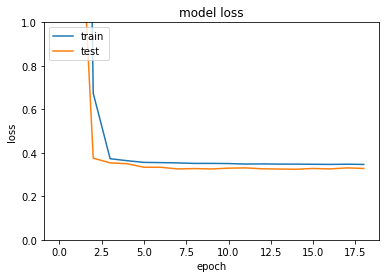

In [102]:
# list all data in history
'''
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
# axes = plt.gca()
# axes.set_xlim([0,120])
# axes.set_ylim([90,100])
#plt.savefig('acc.png')  # save the figure to file
plt.show()
#plt.close()
'''
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
#plt.savefig('loss.png')
#plt.show()
plt.ylim([0,1])
plt.show()
#plt.close()

In [19]:
X_test = X_test.reshape(X_test.shape[0],244,1)

In [103]:
y_test=model.predict(X_test)

In [104]:
y_test[:,0].shape

(7662,)

In [105]:
df_sub = pd.DataFrame({'id': id_test, 'price_doc': y_test[:,0]})

df_sub.to_csv('sub 2017-04-30_rmsle_decay.csv', index=False) 

# old LB score  0.47631

#Epoch 25/25
#8s - loss: 0.3268 - acc: 0.0000e+00 - val_loss: 0.3183 - val_acc: 0.0000e+00, now  0.48978


#0.50647 with decay